In [1]:
import os
import cv2
import random
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import functools, operator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
import pandas as pd
df = pd.read_csv('data.csv')
df

,VideoID,Description
0,-4wsuPCjDBc_5_15,a squirrel is eating a peanut in it s shell
1,-4wsuPCjDBc_5_15,a chipmunk is eating
2,-4wsuPCjDBc_5_15,a chipmunk is eating a peanut
3,-4wsuPCjDBc_5_15,a chipmunk is eating a nut
4,-4wsuPCjDBc_5_15,a squirrel is eating a nut
...,...,...
80783,zxB4dFJhHR8_1_9,a girl riding a bicycle
80784,zxB4dFJhHR8_1_9,a smiling girl wearing backpack is riding a bike
80785,zxB4dFJhHR8_1_9,the girl rode her bike at the beach
80786,zzit5b_-ukg_5_20,a boy is doing exercise by cycle


In [3]:
videoIDs = list(df.VideoID.unique())
print(len(videoIDs))

1970


In [4]:
def extract_frames_equally_spaced(frames, K):
        n_frames = len(frames)
        splits = np.array_split(range(n_frames), K)
        idx_taken = [s[0] for s in splits]
        sub_frames = []

        for idx in idx_taken:
          sub_frames.append(frames[idx])
        return sub_frames

def pad_frames(frames, limit, jpegs=False):
        last_frame = frames[-1]
        if jpegs:
            frames_padded = frames + [last_frame]*(limit-len(frames))
        else:
            padding = np.asarray([last_frame * 0.]*(limit-len(frames)))
            frames_padded = np.concatenate([frames, padding], axis=0)
        return frames_padded

def video_to_frames(input_loc,K,motion=False):
    cap = cv2.VideoCapture(input_loc)
    
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    count = 0

    if motion is True:
      K = max(video_length,50)

    frames=[]
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            continue
        frames.append(frame)
        count = count + 1
        
        if (count > (video_length-1)):
            cap.release()
            break
    if len(frames) < K:
        frames = pad_frames(frames,K,True)
    else:
        frames = extract_frames_equally_spaced(frames,K)
    
    return frames

def resize_frames(frames):
  new_frames = []
  for frame in frames:
    new_frame = cv2.resize(frame,(224,224))
    new_frames.append(new_frame)
  
  return new_frames

K=28

In [5]:
#Googlenet model
def get_model():
  i = tf.keras.layers.Input([224, 224, 3], dtype = tf.float32)
  x = tf.keras.applications.inception_v3.preprocess_input(i)
  model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3),pooling='avg')
  out = model(x)
  model=tf.keras.models.Model(inputs=[i], outputs=out)
  return model
  # model.summary()

In [6]:
#Extract global features for training 

def extract_global_features(save=False):
  if not os.path.exists('global_features'):
    os.makedirs('global_features')

  model = get_model()
  unfound={}
  for index, id in enumerate(videoIDs):
    path = '.\MSVD Dataset\Training\Videos\\'
    path+=id
    path+='.avi'
    try:
        frames = video_to_frames(path,K)
        frames = resize_frames(frames)
        frames = np.array(frames)

        feature_vector=model.predict(frames,batch_size=128)
        feature_path='global_features/'+id+'.npy'
        np.save(feature_path, feature_vector)

        print(index,':',id)
    except:
        unfound[index]=id
        

  if save is True:
    !zip -r global_features.zip global_features
    !cp 'global_features.zip' 'drive/MyDrive/it416/'

In [65]:
extract_global_features(save=True)

1/1 [==============================] - 1s 1s/step
0 : -4wsuPCjDBc_5_15
1/1 [==============================] - 1s 753ms/step
1 : -7KMZQEsJW4_205_208
1/1 [==============================] - 1s 675ms/step
2 : -8y1Q0rA3n8_108_115
1/1 [==============================] - 1s 705ms/step
3 : -8y1Q0rA3n8_95_102
1/1 [==============================] - 1s 641ms/step
4 : -9CUm-2cui8_39_44
1/1 [==============================] - 1s 628ms/step
5 : -AwoiGR6c8M_10_14
1/1 [==============================] - 1s 623ms/step
6 : -Cv5LsqKUXc_17_25
1/1 [==============================] - 1s 721ms/step
7 : -Cv5LsqKUXc_71_76
1/1 [==============================] - 1s 623ms/step
8 : -DKuLXYoY3g_14_20
1/1 [==============================] - 1s 629ms/step
9 : -DRy7rBg0IQ_31_37
1/1 [==============================] - 1s 629ms/step
10 : -FugkxLmGO4_5_16
1/1 [==============================] - 1s 637ms/step
11 : -Ms9tsWmhyU_80_95
1/1 [==============================] - 1s 637ms/step
13 : -_aaMGK6GGw_57_61
1/1 [=================

1/1 [==============================] - 1s 668ms/step
215 : 4t5POXt2e68_5_11
1/1 [==============================] - 1s 675ms/step
216 : 4wT7zM8XgXQ_5_11
1/1 [==============================] - 1s 669ms/step
217 : 4xVGpDmA4lE_23_33
1/1 [==============================] - 1s 666ms/step
218 : 4yYapi-5QYQ_33_57
1/1 [==============================] - 1s 668ms/step
219 : 4yf2WP6K1gQ_28_32
1/1 [==============================] - 1s 686ms/step
220 : 4z3b4mnw5y4_56_60
1/1 [==============================] - 1s 738ms/step
221 : 4zPSShqsq-o_3_16
1/1 [==============================] - 1s 717ms/step
222 : 5-8z5U-o4O4_0_3
1/1 [==============================] - 1s 740ms/step
223 : 504gE1DA_4g_1_6
1/1 [==============================] - 1s 741ms/step
224 : 53dc4z7HLyg_16_23
1/1 [==============================] - 1s 663ms/step
225 : 53dc4z7HLyg_25_29
1/1 [==============================] - 1s 659ms/step
226 : 57C93mpt6Xo_358_368
1/1 [==============================] - 1s 763ms/step
227 : 5AEldiUP408_65_71
1/1 

1/1 [==============================] - 1s 683ms/step
427 : Ar70p1_LcfM_2_20
1/1 [==============================] - 1s 685ms/step
428 : ArEWo8pERFc_17_21
1/1 [==============================] - 1s 726ms/step
429 : Ayh26v6Nies_17_22
1/1 [==============================] - 1s 672ms/step
430 : AysIdzGF-7M_6_14
1/1 [==============================] - 1s 679ms/step
431 : AzMrltkXGJk_0_10
1/1 [==============================] - 1s 668ms/step
432 : B-Lsf7ZKf5c_10_25
1/1 [==============================] - 1s 671ms/step
433 : B4foOe9kUgY_0_8
1/1 [==============================] - 1s 962ms/step
434 : B7mP4zoDMwM_0_17
1/1 [==============================] - 1s 694ms/step
435 : BAf3LXFUaGs_28_38
1/1 [==============================] - 1s 670ms/step
436 : BApIQn69EVE_10_16
1/1 [==============================] - 1s 675ms/step
437 : BE_uxYK9uz0_150_168
1/1 [==============================] - 1s 692ms/step
438 : BE_uxYK9uz0_49_56
1/1 [==============================] - 1s 706ms/step
439 : BGG0uYWZBdw_6_12
1/1 

1/1 [==============================] - 1s 670ms/step
639 : IpHJffM3G1c_464_470
1/1 [==============================] - 1s 670ms/step
640 : ItFqogTmAvQ_240_246
1/1 [==============================] - 1s 684ms/step
641 : ItFqogTmAvQ_281_286
1/1 [==============================] - 1s 670ms/step
642 : ItFqogTmAvQ_361_365
1/1 [==============================] - 1s 683ms/step
643 : ItFqogTmAvQ_389_395
1/1 [==============================] - 1s 709ms/step
644 : ItFqogTmAvQ_48_52
1/1 [==============================] - 1s 698ms/step
645 : Ixw6wmoC_xg_116_126
1/1 [==============================] - 1s 698ms/step
646 : Ixw6wmoC_xg_60_70
1/1 [==============================] - 1s 693ms/step
647 : IytNBm8WA1c_63_67
1/1 [==============================] - 1s 679ms/step
648 : J---aiyznGQ_0_6
1/1 [==============================] - 1s 671ms/step
649 : J3_hkgu6MGc_43_52
1/1 [==============================] - 1s 676ms/step
650 : J4otiwOjQy8_98_112
1/1 [==============================] - 1s 705ms/step
651 : J7zb8Y

1/1 [==============================] - 1s 683ms/step
745 : MSrJTeKNzdI_32_36
1/1 [==============================] - 1s 665ms/step
746 : MTjrZthHwJQ_2_11
1/1 [==============================] - 1s 668ms/step
747 : MTkGPfMRXtc_5_21
1/1 [==============================] - 1s 681ms/step
748 : MW21lp833Vo_143_149
1/1 [==============================] - 1s 671ms/step
749 : MW21lp833Vo_8_16
1/1 [==============================] - 1s 667ms/step
750 : MWvCcwTw7Ac_154_181
1/1 [==============================] - 1s 691ms/step
751 : MWvCcwTw7Ac_78_86
1/1 [==============================] - 1s 724ms/step
752 : MWzeInQaUk4_12_20
1/1 [==============================] - 1s 767ms/step
753 : MY-rGamtAJc_6_22
1/1 [==============================] - 1s 706ms/step
754 : M_TP6UTrh30_343_358
1/1 [==============================] - 1s 703ms/step
755 : MdOAr_4FJvc_5_15
1/1 [==============================] - 1s 685ms/step
756 : MoqC84sXu88_47_59
1/1 [==============================] - 1s 687ms/step
757 : MqS82kBtUHQ_0_12

1/1 [==============================] - 1s 656ms/step
957 : UXs3eq68ZjE_508_513
1/1 [==============================] - 1s 670ms/step
958 : UbmZAe5u5FI_101_110
1/1 [==============================] - 1s 680ms/step
959 : UbmZAe5u5FI_111_115
1/1 [==============================] - 1s 668ms/step
960 : UbmZAe5u5FI_132_141
1/1 [==============================] - 1s 675ms/step
961 : UbmZAe5u5FI_16_23
1/1 [==============================] - 1s 717ms/step
962 : UbmZAe5u5FI_26_33
1/1 [==============================] - 1s 704ms/step
963 : UbmZAe5u5FI_36_40
1/1 [==============================] - 1s 668ms/step
964 : UbmZAe5u5FI_44_55
1/1 [==============================] - 1s 679ms/step
965 : UbmZAe5u5FI_60_70
1/1 [==============================] - 1s 677ms/step
966 : UbmZAe5u5FI_88_98
1/1 [==============================] - 1s 663ms/step
967 : Uc63MFVwfrs_355_372
1/1 [==============================] - 1s 672ms/step
968 : Uc63MFVwfrs_360_372
1/1 [==============================] - 1s 699ms/step
969 : Ud3Qy

1/1 [==============================] - 1s 667ms/step
1246 : d-2C_N5anww_1_3
1/1 [==============================] - 1s 647ms/step
1247 : d1zdJO3CqVw_1_35
1/1 [==============================] - 1s 644ms/step
1248 : d4AGWnHJcaY_6_19
1/1 [==============================] - 1s 653ms/step
1249 : d7Gs0uGFLh0_5_13
1/1 [==============================] - 1s 643ms/step
1250 : d7eGypGOlOc_13_22
1/1 [==============================] - 1s 653ms/step
1251 : dEn5E-TNezw_13_23
1/1 [==============================] - 1s 657ms/step
1252 : dJ3ba9zwx6c_5_15
1/1 [==============================] - 1s 653ms/step
1253 : dJCtOz32dnw_40_60
1/1 [==============================] - 1s 651ms/step
1254 : dJEoDaA6VXc_1_19
1/1 [==============================] - 1s 647ms/step
1255 : dMH0bHeiRNg_3_14
1/1 [==============================] - 1s 667ms/step
1256 : dP15zlyra3c_0_10
1/1 [==============================] - 1s 651ms/step
1257 : dQmaVQZz7EE_1_18
1/1 [==============================] - 1s 673ms/step
1258 : dZBIdRGKRhM_13

1/1 [==============================] - 1s 674ms/step
1351 : gbW9f8xydks_0_10
1/1 [==============================] - 1s 667ms/step
1352 : gbbRwBZuhzI_26_40
1/1 [==============================] - 1s 682ms/step
1353 : ge7OOILJA6U_20_25
1/1 [==============================] - 1s 674ms/step
1354 : ggWzbEFC-RE_1_11
1/1 [==============================] - 1s 673ms/step
1355 : ggic669elLM_200_215
1/1 [==============================] - 1s 683ms/step
1356 : ghynaoVNwZc_1_20
1/1 [==============================] - 1s 677ms/step
1357 : giLxPCgLLqg_9_19
1/1 [==============================] - 1s 674ms/step
1358 : gjVBEJGHrXk_26_38
1/1 [==============================] - 1s 659ms/step
1359 : glii-kazad8_21_29
1/1 [==============================] - 1s 669ms/step
1360 : glrijRGnmc0_211_215
1/1 [==============================] - 1s 677ms/step
1361 : gnEE6oWoz7U_124_132
1/1 [==============================] - 1s 675ms/step
1362 : gp8XjWSoP2k_0_10
1/1 [==============================] - 1s 681ms/step
1363 : gqS

1/1 [==============================] - 1s 688ms/step
1560 : mFCf8lLXrUc_25_35
1/1 [==============================] - 1s 692ms/step
1561 : mFCf8lLXrUc_36_57
1/1 [==============================] - 1s 708ms/step
1562 : mHv4iJ9Yr1g_10_16
1/1 [==============================] - 1s 877ms/step
1563 : mJ9eRvxjLc4_0_16
1/1 [==============================] - 1s 975ms/step
1564 : mOZkcBcWR8o_6_12
1/1 [==============================] - 1s 885ms/step
1565 : mYzajpeAWuA_100_112
1/1 [==============================] - 1s 984ms/step
1566 : mZVPkPqwzR4_38_45
1/1 [==============================] - 1s 839ms/step
1567 : mbesJaS6vwg_187_195
1/1 [==============================] - 1s 985ms/step
1568 : me1D1WZ0yNM_120_124
1/1 [==============================] - 1s 817ms/step
1569 : mfJjIOfj6D8_3_10
1/1 [==============================] - 1s 774ms/step
1570 : mmSQTI6gMNQ_120_128
1/1 [==============================] - 1s 736ms/step
1571 : mmSQTI6gMNQ_15_21
1/1 [==============================] - 1s 697ms/step
1572 :

1/1 [==============================] - 1s 695ms/step
1769 : s_ldnx8_etY_32_54
1/1 [==============================] - 1s 673ms/step
1770 : sb1dX5xAFvk_10_17
1/1 [==============================] - 1s 690ms/step
1771 : seTkGZlEU64_81_110
1/1 [==============================] - 1s 713ms/step
1772 : shPymuahrsc_5_12
1/1 [==============================] - 1s 700ms/step
1773 : sm0OYD0NSbQ_51_59
1/1 [==============================] - 1s 691ms/step
1774 : suj4VNfZz5E_33_50
1/1 [==============================] - 1s 684ms/step
1775 : sv5YlZspb30_10_20
1/1 [==============================] - 1s 716ms/step
1776 : swJ0zhVJ8DU_15_21
1/1 [==============================] - 1s 709ms/step
1777 : swKrHEeOj9c_4_8
1/1 [==============================] - 1s 685ms/step
1778 : t3VPeyYL-fI_35_39
1/1 [==============================] - 1s 697ms/step
1779 : t4aPGtx7e6k_0_10
1/1 [==============================] - 1s 677ms/step
1780 : t4vP-cXXWkY_14_20
1/1 [==============================] - 1s 716ms/step
1781 : t8Nf1MK

  adding: global_features/0hyZ__3YhZc_632_637.npy (164 bytes security) (deflated 11%)
  adding: global_features/0I4VKj4d0WI_24_40.npy (164 bytes security) (deflated 11%)
  adding: global_features/0IDJG0q9j_k_1_24.npy (164 bytes security) (deflated 11%)
  adding: global_features/0k1Ak8aTMVI_4_12.npy (164 bytes security) (deflated 11%)
  adding: global_features/0lh_UWF9ZP4_103_110.npy (164 bytes security) (deflated 11%)
  adding: global_features/0lh_UWF9ZP4_138_145.npy (164 bytes security) (deflated 11%)
  adding: global_features/0lh_UWF9ZP4_148_155.npy (164 bytes security) (deflated 13%)
  adding: global_features/0lh_UWF9ZP4_157_160.npy (164 bytes security) (deflated 11%)
  adding: global_features/0lh_UWF9ZP4_165_170.npy (164 bytes security) (deflated 11%)
  adding: global_features/0lh_UWF9ZP4_174_178.npy (164 bytes security) (deflated 12%)
  adding: global_features/0lh_UWF9ZP4_178_182.npy (164 bytes security) (deflated 11%)
  adding: global_features/0lh_UWF9ZP4_183_190.npy (164 bytes s

'cp' is not recognized as an internal or external command,
operable program or batch file.



  adding: global_features/Cxxx6wJ1jNo_0_10.npy (164 bytes security) (deflated 12%)
  adding: global_features/c_-eFL7Sfw4_19_35.npy (164 bytes security) (deflated 11%)
  adding: global_features/C_1cnNdMwxY_0_8.npy (164 bytes security) (deflated 11%)
  adding: global_features/C_DDjCRxTxQ_1_4.npy (164 bytes security) (deflated 12%)
  adding: global_features/c_XV7nPoRg8_2_12.npy (164 bytes security) (deflated 10%)
  adding: global_features/d-2C_N5anww_1_3.npy (164 bytes security) (deflated 11%)
  adding: global_features/D1tTBncIsm8_198_205.npy (164 bytes security) (deflated 11%)
  adding: global_features/D1tTBncIsm8_248_254.npy (164 bytes security) (deflated 12%)
  adding: global_features/D1tTBncIsm8_681_688.npy (164 bytes security) (deflated 11%)
  adding: global_features/D1tTBncIsm8_725_740.npy (164 bytes security) (deflated 11%)
  adding: global_features/D1tTBncIsm8_841_848.npy (164 bytes security) (deflated 12%)
  adding: global_features/D1X6qXkLjYE_41_49.npy (164 bytes security) (def

In [7]:
# Extracting Motion Features
# import skvideo.io
import os
import importlib as imp
from c3d import C3D
from keras.models import Model
import sports1M_utils
imp.reload(sports1M_utils)

def extract_motion_features(save=False):
  if not os.path.exists('motion_features1'):
    os.makedirs('motion_features1')

  base_model = C3D(weights='sports1M')
  model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc6').output)

  for index, id in enumerate(videoIDs[1826:]):
    path = '.\MSVD Dataset\Training\Videos\\'
    path+=id
    path+='.avi'
    unfound2={}
    try:
        frames = video_to_frames(path,K,True)
        frames = resize_frames(frames)
        frames = np.array(frames)
        
        windows = []
        org_vid = frames
        vid = []
        motion_features_video = []
        for i in range(len(frames)):
          vid.append(frames[i])
          if i==15:
            windows.append(vid)
          elif i>=16:
            vid.pop(0)
            windows.append(vid)

        windows = extract_frames_equally_spaced(windows,28)
        for window in windows:
          x = sports1M_utils.preprocess_input(np.array(window))
          feature_vector = model.predict(x) 
          feature_vector = feature_vector[0]
          feature_vector = np.array(feature_vector)

          motion_features_video.append(feature_vector)
        motion_features_video = np.array(motion_features_video)
        print("yeah")
        path='motion_features1/'+id+'.npy'
        np.save(path, motion_features_video)
        
#         if index%200==0 and index>0:
#           !zip -r motion_features1.zip motion_features1
#           !cp 'motion_features1.zip' 'drive/MyDrive/IT416/'
        print(index,':',motion_features_video.shape)
    except:
        unfound2[index]=id

#   if save is True:
#     !zip -r motion_features1.zip motion_features1
#     !cp 'motion_features1.zip' 'drive/MyDrive/IT416/'

In [8]:
extract_motion_features(save=True)

1/1 [==============================] - 0s 345ms/step
yeah
0 : (28, 4096)
1/1 [==============================] - 0s 359ms/step
yeah
1 : (28, 4096)
1/1 [==============================] - 0s 391ms/step
yeah
2 : (28, 4096)
1/1 [==============================] - 0s 351ms/step
yeah
3 : (28, 4096)
1/1 [==============================] - 0s 348ms/step
yeah
4 : (28, 4096)
1/1 [==============================] - 0s 350ms/step
yeah
5 : (28, 4096)
1/1 [==============================] - 0s 360ms/step
yeah
6 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
7 : (28, 4096)
1/1 [==============================] - 0s 354ms/step
yeah
8 : (28, 4096)
1/1 [==============================] - 0s 361ms/step
yeah
9 : (28, 4096)
1/1 [==============================] - 0s 350ms/step


1/1 [==============================] - 0s 344ms/step
yeah
10 : (28, 4096)
1/1 [==============================] - 0s 359ms/step
yeah
11 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
12 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
13 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
14 : (28, 4096)
1/1 [==============================] - 0s 341ms/step
yeah
15 : (28, 4096)
1/1 [==============================] - 0s 359ms/step
yeah
16 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
17 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
18 : (28, 4096)
1/1 [==============================] - 0s 381ms/step
yeah
19 : (28, 4096)
1/1 [==============================] - 0s 359ms/step
yeah
20 : (28, 4096)
1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 360ms/step
yeah
21 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
22 : (28, 4096)
1/1 [==============================] - 0s 393ms/step
yeah
23 : (28, 4096)
1/1 [==============================] - 1s 502ms/step
yeah
24 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
25 : (28, 4096)
1/1 [==============================] - 0s 359ms/step
yeah
26 : (28, 4096)
1/1 [==============================] - 0s 350ms/step
yeah
27 : (28, 4096)
1/1 [==============================] - 0s 351ms/step
yeah
28 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
29 : (28, 4096)
1/1 [==============================] - 0s 433ms/step
yeah
31 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
32 : (28, 4096)
1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 344ms/step
yeah
33 : (28, 4096)
1/1 [==============================] - 0s 359ms/step
yeah
34 : (28, 4096)
1/1 [==============================] - 0s 485ms/step
yeah
35 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
36 : (28, 4096)
1/1 [==============================] - 0s 344ms/step
yeah
37 : (28, 4096)


In [10]:
found=[]
for i in os.listdir('.\global_features'):
    found.append(i.split('.')[0])

In [11]:
#Prepare training and validation data
df = pd.read_csv('data.csv')
train_ids = found
train_split = 0.85
train_list=[]
vocab_list=[]
for i in range(len(train_ids)):
  df_temp=df.loc[df['VideoID']==train_ids[i]]
  for _, row in df_temp.iterrows():
    caption = "<bos> " + row['Description'] + " <eos>"
    if len(caption.split()) > 10 or len(caption.split()) < 6:
        continue
    else:
        train_list.append([caption, train_ids[i]])
random.shuffle(train_list)
training_list = train_list[:int(len(train_list)*train_split)]
validation_list = train_list[int(len(train_list)*train_split):]

for train in training_list:
    vocab_list.append(train[0])
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(vocab_list)

In [13]:
x_data_global={}
for i,id in enumerate(train_ids):
  feat_path = 'global_features/'+id+'.npy'
  features=np.load(feat_path)
  x_data_global[id]=features
print(len(x_data_global))

1782


In [14]:
# x_data_motion={}
# for i,id in enumerate(train_ids):
#   feat_path = 'motion_features1/'+id+'.npy'
#   features=np.load(feat_path)
#   x_data_motion[id]=features
# print(len(x_data_motion))

In [15]:
# x_data_local={}
# for i,id in enumerate(train_ids):
#   feat_path = 'local_features1/'+id+'.npy'
#   features=np.load(feat_path)
#   x_data_local[id]=features
# print(len(x_data_local))

In [16]:
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

# Hyperparameters
time_steps_encoder=28
num_encoder_tokens=2048
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=320
epochs = 25
save_model_path = './'

#Data generator for loading data in batches while training
def load_dataset(training_list):
  encoder_input_data_global = []
  decoder_input_data = []
  decoder_target_data = []
  train_videoIDs = []
  videoSeq = []
  for idx, cap in enumerate(training_list):
    caption = cap[0]
    train_videoIDs.append(cap[1])
    videoSeq.append(caption)
  train_sequences = tokenizer.texts_to_sequences(videoSeq)
  train_sequences = np.array(train_sequences)
  train_sequences = pad_sequences(train_sequences, padding='post', truncating='post',
                                  maxlen=10)
  file_size = len(train_sequences)
  n = 0
  for i in range(epochs): #epochs
    for idx in range(0, file_size):
      n += 1
      encoder_input_data_global.append(x_data_global[train_videoIDs[idx]])
      y = tf.keras.utils.to_categorical(train_sequences[idx], 1500)
      decoder_input_data.append(y[:-1])
      decoder_target_data.append(y[1:])
      if n == batch_size: #batch size
        encoder_input_global = np.array(encoder_input_data_global)
        decoder_input = np.array(decoder_input_data)
        decoder_target = np.array(decoder_target_data)
        encoder_input_data_global = []
        decoder_input_data = []
        decoder_target_data = []
        n = 0
        yield ([encoder_input_global, decoder_input], decoder_target)
     

In [22]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [23]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate, Dropout

In [25]:
from tensorflow.keras.layers import AdditiveAttention

In [70]:
decoder_inputs

<KerasTensor: shape=(None, 10, 1500) dtype=float32 (created by layer 'decoder_inputs')>

In [30]:
encoder_inputs_global = tf.keras.layers.Input(shape=(time_steps_encoder, 2048), name="encoder_inputs_global")
encoder=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(latent_dim, return_sequences=True,return_state=True), merge_mode='concat')

encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = encoder(encoder_inputs_global)
final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

encoder_states =[final_enc_h, final_enc_c]


decoder_inputs = tf.keras.layers.Input(shape=(time_steps_decoder, num_decoder_tokens), name="decoder_inputs")
decoder_lstm = tf.keras.layers.LSTM(latent_dim*2, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _ , _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)


attention_result = AdditiveAttention(use_scale=True)([decoder_outputs, encoder_outputs1])
# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

    
decoder_outputs = tf.keras.layers.Dropout(0.3)(decoder_concat_input)
decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation='sigmoid', name='decoder_sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

model = tf.keras.models.Model([encoder_inputs_global,decoder_inputs], decoder_outputs)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs_global (InputLa  [(None, 28, 2048)]  0           []                               
 yer)                                                                                             
                                                                                                  
 bidirectional_8 (Bidirectional  [(None, 28, 1024),  10489856    ['encoder_inputs_global[0][0]']  
 )                               (None, 512),                                                     
                                 (None, 512),                                                     
                                 (None, 512),                                                     
                                 (None, 512)]                                               

In [31]:
train = load_dataset(training_list)
valid = load_dataset(validation_list)


opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                            factor=0.1, patience=5, verbose=1,
                                            mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')

validation_steps = len(validation_list)//batch_size
steps_per_epoch = len(training_list)//batch_size

history=model.fit(train, validation_data=valid, validation_steps=validation_steps,
        epochs=epochs, steps_per_epoch=steps_per_epoch,
        callbacks=[reduce_lr])

if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)


Epoch 1/25
145/145 [==============================] - 555s 4s/step - loss: 3.1137 - accuracy: 0.4345 - val_loss: 2.5685 - val_accuracy: 0.4972 - lr: 3.0000e-04
Epoch 2/25
145/145 [==============================] - 530s 4s/step - loss: 2.3492 - accuracy: 0.5417 - val_loss: 2.0481 - val_accuracy: 0.5863 - lr: 3.0000e-04
Epoch 3/25
145/145 [==============================] - 534s 4s/step - loss: 1.9059 - accuracy: 0.6075 - val_loss: 1.7349 - val_accuracy: 0.6378 - lr: 3.0000e-04
Epoch 4/25
145/145 [==============================] - 535s 4s/step - loss: 1.6397 - accuracy: 0.6490 - val_loss: 1.5641 - val_accuracy: 0.6663 - lr: 3.0000e-04
Epoch 5/25
145/145 [==============================] - 534s 4s/step - loss: 1.4767 - accuracy: 0.6747 - val_loss: 1.4522 - val_accuracy: 0.6839 - lr: 3.0000e-04
Epoch 6/25
145/145 [==============================] - 529s 4s/step - loss: 1.3739 - accuracy: 0.6896 - val_loss: 1.3922 - val_accuracy: 0.6927 - lr: 3.0000e-04
Epoch 7/25
145/145 [====================

In [87]:
encoder_model = tf.keras.models.Model(encoder_inputs_global, outputs = [encoder_outputs1,encoder_states])


In [88]:
encoder_model.save(os.path.join(save_model_path, 'encoder_model.h5'))

In [162]:

decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim*2,))
decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs = tf.keras.layers.Input(shape=(time_steps_decoder, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

attention_layer = AdditiveAttention(name='attention_layer')
attention_result = attention_layer([decoder_outputs, encoder_outputs1])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_concat_input)
decoder_model = Model(
    [decoder_inputs, encoder_outputs1] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

# Saving models
decoder_model.save('my_decoder_model.h5')


In [164]:
[decoder_inputs, encoder_outputs1] + decoder_states_inputs

[<KerasTensor: shape=(None, None, 1500) dtype=float32 (created by layer 'input_107')>,
 <KerasTensor: shape=(None, 28, 1024) dtype=float32 (created by layer 'bidirectional_8')>,
 <KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'input_105')>,
 <KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'input_106')>]

In [102]:
decoder_model.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_71 (InputLayer)          [(None, 10, 1500)]   0           []                               
                                                                                                  
 input_69 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_70 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 lstm_13 (LSTM)                 [(None, 10, 1024),   10342400    ['input_71[0][0]',               
                                 (None, 1024),                    'input_69[0][0]',        

In [103]:
with open(os.path.join(save_model_path, 'tokenizer' + str(num_decoder_tokens)), 'wb') as file:
    joblib.dump(tokenizer, file)

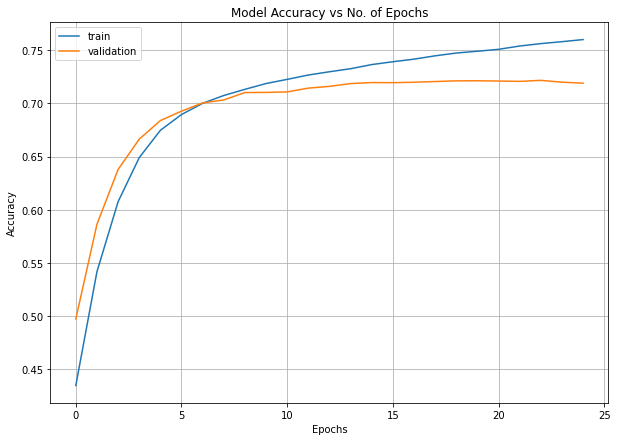

In [104]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.grid(True)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs No. of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

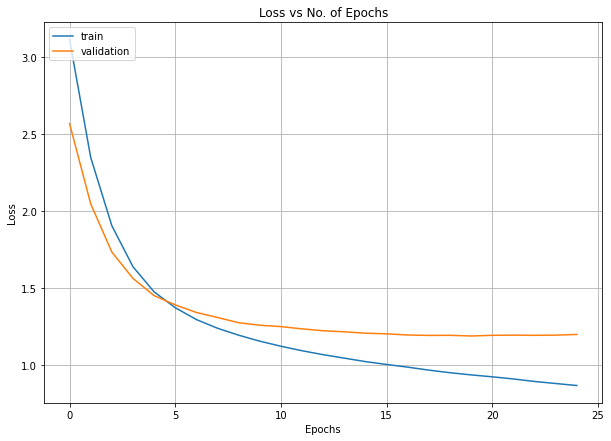

In [105]:
plt.figure(figsize=(10,7))
plt.grid(True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs No. of Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [106]:
file = open('testing_id.txt','w')
for id in found[-100:]:
    print(id,file=file)
file.close()

In [53]:
validation_list

[['<bos> a bikeman is stunting on his bike <eos>', 'AjZ-R3LFMzo_5_10'],
 ['<bos> a short clip from the hollywood movie rocky <eos>',
  '_1vy2HIN60A_32_40'],
 ['<bos> a dog is sniffing a duckling <eos>', 'ficwZQYmRLE_5_20'],
 ['<bos> the person is explaining about skeleton <eos>',
  'ggic669elLM_200_215'],
 ['<bos> a man melted butter in a pan <eos>', 'Fe4tO5vW9_E_64_70'],
 ['<bos> the man is playing with a wooden flute <eos>', 'W8l_ezoU8Lc_76_86'],
 ['<bos> one man is cutting something with knife <eos>',
  'WPG-BIWOrG4_672_677'],
 ['<bos> the boy is playing the guitar <eos>', 'dQmaVQZz7EE_1_18'],
 ['<bos> a boys are running <eos>', 'u4T76jsPin0_0_11'],
 ['<bos> a claymation puppet rides a bike <eos>', 'uZEGu-TA2cU_42_58'],
 ['<bos> a person is cleaning cd <eos>', 'vE1gvaM3iAs_39_46'],
 ['<bos> a dog on the staircase <eos>', '4kQnrKvOTNg_15_24'],
 ['<bos> a cat is sleeping <eos>', '5JLi7L1Kwp8_23_30'],
 ['<bos> the man put the pizza into the oven <eos>', '6owu8Mow0_g_384_389'],
 ['<bos>

In [118]:
decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim*2,))
decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs = tf.keras.layers.Input(shape=(time_steps_decoder, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

attention_layer = AdditiveAttention(name='attention_layer')
attention_result = attention_layer([decoder_outputs, encoder_outputs1])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_concat_input)
inf_decoder_model = Model(
[decoder_inputs, encoder_outputs1] + decoder_states_inputs,
[decoder_outputs] + decoder_states
)
inf_decoder_model.load_weights(os.path.join('my_decoder_model.h5'))

In [119]:
# class to perform inference on all test files and save as test_output.txt
class Video2Text(object):
    ''' Initialize the parameters for the model '''
    def __init__(self):
        self.latent_dim = 512
        self.num_encoder_tokens = 2048
        self.num_decoder_tokens = 1500
        self.time_steps_encoder = 28
        self.time_steps_decoder = None
        self.max_probability = -1

        # processed data
        self.encoder_input_data = []
        self.decoder_input_data = []
        self.decoder_target_data = []
        self.tokenizer = None

        # models
        self.encoder_model = None
        self.decoder_model = None
        self.inf_encoder_model = None
        self.inf_decoder_model = None
        self.save_model_path = './'
        self.test_path_global = 'global_features'
        self.test_path_motion = 'motion_features1'
        self.test_path_local = 'local_features1'

    def load_inference_models(self):
        # load tokenizer
        with open(os.path.join('tokenizer' + str(self.num_decoder_tokens)), 'rb') as file:
            self.tokenizer = joblib.load(file)

        # inference encoder model
        self.inf_encoder_model = tf.keras.models.load_model(os.path.join('encoder_model.h5'))


        decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim*2,))
        decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim*2,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        decoder_inputs = tf.keras.layers.Input(shape=(time_steps_decoder, num_decoder_tokens))
        decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
        decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
        decoder_states = [state_h_dec, state_c_dec]

        attention_layer = AdditiveAttention(name='attention_layer')
        attention_result = attention_layer([decoder_outputs, encoder_outputs1])

        decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

        decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_concat_input)
        inf_decoder_model = Model(
            [decoder_inputs, encoder_outputs1] + decoder_states_inputs,
            [decoder_outputs] + decoder_states
        )
        self.inf_decoder_model.load_weights(os.path.join('my_decoder_model.h5'))
        print('Loaded Inference Model')

    
    def index_to_word(self):
        # inverts word tokenizer
        index_to_word = {value: key for key, value in self.tokenizer.word_index.items()}
        return index_to_word
    
    def greedy_search(self, f):
        """
        :param f: the loaded numpy array after creating videos to frames and extracting features
        :return: the final sentence which has been predicted greedily
        """
        inv_map = self.index_to_word()
        states_value = self.inf_encoder_model.predict(f.reshape(-1, 28, 2048))
        # states_value = np.array(states_value).reshape((1, 512))
        target_seq = np.zeros((1, 1, 1500))
        sentence = ''
        target_seq[0, 0, self.tokenizer.word_index['bos']] = 1
        for i in range(15):
            output_tokens, h, c = self.inf_decoder_model.predict([target_seq] + [states_value])
            states_value = [h, c]
            output_tokens = output_tokens.reshape(self.num_decoder_tokens)
            y_hat = np.argmax(output_tokens)
            if y_hat == 0:
                continue
            if inv_map[y_hat] is None:
                break
            else:
                sentence = sentence + inv_map[y_hat] + ' '
                target_seq = np.zeros((1, 1, 1500))
                target_seq[0, 0, y_hat] = 1
        return ' '.join(sentence.split()[:-1])

    def decode_sequence2bs(self, input_seq):
        states_value = self.inf_encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_decoder_tokens))
        target_seq[0, 0, self.tokenizer.word_index['bos']] = 1
        self.beam_search(target_seq, states_value,[],[],0)
        return decode_seq

    def beam_search(self, target_seq, states_value, prob,  path, lens):
        global decode_seq
        node = 2
        output_tokens, h, c = self.inf_decoder_model.predict(
            [target_seq] + states_value)
        output_tokens = output_tokens.reshape((self.num_decoder_tokens))
        sampled_token_index = output_tokens.argsort()[-node:][::-1]
        states_value = [h, c]
        for i in range(node):
            if sampled_token_index[i] == 0:
                sampled_char = ''
            else:
                sampled_char = list(self.tokenizer.word_index.keys())[list(self.tokenizer.word_index.values()).index(sampled_token_index[i])]
            MAX_LEN = 10
            if(sampled_char != 'eos' and lens <= MAX_LEN):
                p = output_tokens[sampled_token_index[i]]
                if(sampled_char == ''):
                    p = 1
                prob_new = list(prob)
                prob_new.append(p)
                path_new = list(path)
                path_new.append(sampled_char)
                target_seq = np.zeros((1, 1, self.num_decoder_tokens))
                target_seq[0, 0, sampled_token_index[i]] = 1.
                self.beam_search(target_seq, states_value, prob_new, path_new, lens+1)
            else:
                p = output_tokens[sampled_token_index[i]]
                prob_new = list(prob)
                prob_new.append(p)
                p = functools.reduce(operator.mul, prob_new, 1)
                if(p > self.max_probability):
                    decode_seq = path
                    self.max_probability = p

    def decoded_sentence_tuning(self, decoded_sentence):
        decode_str = []
        filter_string = ['bos', 'eos']
        unigram = {}
        last_string = ""
        for idx2, c in enumerate(decoded_sentence):
            if c in unigram:
                unigram[c] += 1
            else:
                unigram[c] = 1
            if(last_string == c and idx2 > 0):
                continue
            if c in filter_string:
                continue
            if len(c) > 0:
                decode_str.append(c)
            if idx2 > 0:
                last_string = c
        return decode_str

    def get_test_data(self, path_global, path_motion, path_local):
        X_test = []
        X_test_filename = []
        with open('testing_id.txt') as testing_file:
            lines = testing_file.readlines()
            for filename in lines:
                filename = filename.strip()
                f1 = np.load(path_global +'/'+ filename + '.npy')
                X_test.append(f1)
                X_test_filename.append(filename)
            X_test = np.array(X_test)
            print('X_test.shape:',X_test.shape)
        return X_test, X_test_filename

    def test(self):
        X_test, X_test_filename = self.get_test_data(os.path.join(self.test_path_global))
        print(len(X_test), len(X_test_filename))
        # generate inference test outputs
        with open(os.path.join('test_output.txt'), 'w') as file:
            for idx, x in enumerate(X_test): 
                file.write(X_test_filename[idx]+',')
              
                decoded_sentence = self.greedy_search(x.reshape(-1, 28, 2048))
                file.write(decoded_sentence)

                file.write('\n')
                # re-init max prob
                self.max_probability = -1

In [120]:
c = Video2Text()
c.load_inference_models()
c.test()

AttributeError: 'NoneType' object has no attribute 'load_weights'

In [122]:
latent_dim = 512
num_encoder_tokens = 2048
num_decoder_tokens = 1500
time_steps_encoder = 28
time_steps_decoder = None
max_probability = -1

# processed data
encoder_input_data = []
decoder_input_data = []
decoder_target_data = []
tokenizer = None

# models
encoder_model = None
decoder_model = None
inf_encoder_model = None
inf_decoder_model = None
save_model_path = './'
test_path_global = 'global_features'
test_path_motion = 'motion_features1'
test_path_local = 'local_features1'

In [124]:
X_test = []
X_test_filename = []
with open('testing_id.txt') as testing_file:
    lines = testing_file.readlines()
    for filename in lines:
        filename = filename.strip()
        f1 = np.load(test_path_global +'/'+ filename + '.npy')
        X_test.append(f1)
        X_test_filename.append(filename)
    X_test = np.array(X_test)
    print('X_test.shape:',X_test.shape)

X_test.shape: (100, 28, 2048)


In [131]:
with open(os.path.join('tokenizer' + str(num_decoder_tokens)), 'rb') as file:
    tokenizer = joblib.load(file)

In [127]:
def index_to_word():
    index_to_word = {value: key for key, value in tokenizer.word_index.items()}
    return index_to_word

In [141]:
def greedy_search(f):
    inv_map = index_to_word()
    states_value = inf_encoder_model.predict(f.reshape(-1, 28, 2048))
    target_seq = np.zeros((1, 1, 1500))
    sentence = ''
    target_seq[0, 0, tokenizer.word_index['bos']] = 1
    for i in range(15):
        output_tokens, h, c = inf_decoder_model.predict([target_seq] + [states_value])
        states_value = [h, c]
        output_tokens = output_tokens.reshape(num_decoder_tokens)
        y_hat = np.argmax(output_tokens)
        if y_hat == 0:
            continue
        if inv_map[y_hat] is None:
            break
        else:
            sentence = sentence + inv_map[y_hat] + ' '
            target_seq = np.zeros((1, 1, 1500))
            target_seq[0, 0, y_hat] = 1
    print(' '.join(sentence.split()[:-1]))

In [215]:
!pip list

Package             Version
------------------- ------------
aiohttp             3.9.3
aiosignal           1.3.1
attrs               23.2.0
beautifulsoup4      4.12.3
certifi             2024.2.2
charset-normalizer  3.3.2
click               8.1.7
colorama            0.4.6
contourpy           1.2.0
cycler              0.12.1
discord             2.3.2
discord.py          2.3.2
filelock            3.13.1
fonttools           4.50.0
frozenlist          1.4.1
future              1.0.0
gdown               5.1.0
gensim              4.3.2
google              3.0.0
google-cloud        0.34.0
google-search       1.1.1
googlesearch-python 1.2.3
graphviz            0.20.3
idna                3.6
inexactsearch       1.0.2
joblib              1.3.2
kiwisolver          1.4.5
lxml                5.1.0
matplotlib          3.8.3
multidict           6.0.5
nltk                3.8.1
numpy               1.26.4
packaging           24.0
pillow              10.2.0
pip                 24.0
pycocoevalcap       1

In [142]:
with open(os.path.join('tokenizer' + str(num_decoder_tokens)), 'rb') as file:
    tokenizer = joblib.load(file)

# inference encoder model
inf_encoder_model = tf.keras.models.load_model(os.path.join('encoder_model.h5'))


decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim*2,))
decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs = tf.keras.layers.Input(shape=(time_steps_decoder, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

attention_layer = AdditiveAttention(name='attention_layer')
attention_result = attention_layer([decoder_outputs, encoder_outputs1])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_concat_input)
inf_decoder_model = Model(
    [decoder_inputs, encoder_outputs1] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
inf_decoder_model.load_weights(os.path.join('my_decoder_model.h5'))
print('Loaded Inference Model')

Loaded Inference Model


In [196]:
newww=inf_encoder_model.predict(X_test[0].reshape(-1, 28, 2048))

1/1 [==============================] - 0s 43ms/step


In [197]:
target_seq = np.zeros((1, 1, 1500))
sentence = ''
target_seq[0, 0, tokenizer.word_index['bos']] = 1

In [207]:
# nv_map = index_to_word()
# states_value = inf_encoder_model.predict(x.reshape(-1, 28, 2048))
# target_seq = np.zeros((1, 1, 1500))
# sentence = ''
# target_seq[0, 0, tokenizer.word_index['bos']] = 1
output_tokens, h, c = inf_decoder_model.predict([target_seq,newww[0]]+newww[1])
states_value = [h, c]
output_tokens = output_tokens.reshape(num_decoder_tokens)
y_hat = np.argmax(output_tokens)

sentence = sentence + inv_map[y_hat] + ' '
target_seq = np.zeros((1, 1, 1500))
target_seq[0, 0, y_hat] = 1

1/1 [==============================] - 0s 19ms/step


In [211]:
newww[0].shape

(1, 28, 1024)

In [213]:
newww[1]

[array([[ 0.03477484,  0.15329675, -0.08020321, ..., -0.72760713,
         -0.01184349, -0.00361964]], dtype=float32),
 array([[ 2.5323416e+01,  1.5458150e-01, -8.0380410e-02, ...,
         -9.3609869e-01, -6.2441599e-02, -3.6290467e-03]], dtype=float32)]

In [214]:
sentence

'eye eye eye eye '

In [160]:
target_seq.shape

(1, 1, 1500)

In [179]:
for idx, x in enumerate(X_test): 
    inv_map = index_to_word()
    states_value = inf_encoder_model.predict(x.reshape(-1, 28, 2048))
    target_seq = np.zeros((1, 1, 1500))
    sentence = ''
    target_seq[0, 0, tokenizer.word_index['bos']] = 1
    for i in range(15):
        output_tokens, h, c = inf_decoder_model.predict([target_seq,states_value[0]]+states_value[1])
        print(output_tokens)
        states_value = [h, c]
        output_tokens = output_tokens.reshape(num_decoder_tokens)
        y_hat = np.argmax(output_tokens)
        if y_hat == 0:
            continue
        if inv_map[y_hat] is None:
            break
        else:
            sentence = sentence + inv_map[y_hat] + ' '
            target_seq = np.zeros((1, 1, 1500))
            target_seq[0, 0, y_hat] = 1
    print(' '.join(sentence.split()[:-1]))

1/1 [==============================] - 0s 21ms/step
[[[0.00032124 0.00060141 0.0013729  ... 0.00070967 0.00046845 0.00086172]]]


ValueError: could not broadcast input array from shape (1500,) into shape (1,)

In [ ]:
inv_map = index_to_word()
states_value = inf_encoder_model.predict(f.reshape(-1, 28, 2048))
target_seq = np.zeros((1, 1, 1500))
sentence = ''
target_seq[0, 0, tokenizer.word_index['bos']] = 1
for i in range(15):
    output_tokens, h, c = inf_decoder_model.predict([target_seq] + [states_value])
    states_value = [h, c]
    output_tokens = output_tokens.reshape(num_decoder_tokens)
    y_hat = np.argmax(output_tokens)
    if y_hat == 0:
        continue
    if inv_map[y_hat] is None:
        break
    else:
        sentence = sentence + inv_map[y_hat] + ' '
        target_seq = np.zeros((1, 1, 1500))
        target_seq[0, 0, y_hat] = 1
print(' '.join(sentence.split()[:-1]))

In [143]:
with open(os.path.join('test_output.txt'), 'w') as file:
    for idx, x in enumerate(X_test): 
        file.write(X_test_filename[idx]+',')

        decoded_sentence = greedy_search(x.reshape(-1, 28, 2048))
        file.write(decoded_sentence)

        file.write('\n')
        # re-init max prob
        self.max_probability = -1

1/1 [==============================] - 0s 264ms/step


ValueError: in user code:

    File "C:\Users\rajendran\Anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\rajendran\Anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\rajendran\Anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\rajendran\Anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\rajendran\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\rajendran\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_34" expects 4 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1, 1500) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1024) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1024) dtype=float32>]


In [ ]:
X_test, X_test_filename = get_test_data(os.path.join(self.test_path_global),os.path.join(self.test_path_motion),os.path.join(self.test_path_local))
print(len(X_test), len(X_test_filename))